Import packages

 First, we set up a grid. We propose a 1000m x 1000m x1000m grid with nodes separated by 10m in every direction. We therefore need 101 nodes in each direction We will work in the SI to simplify the code and not make silly mistakes.

In [1]:
Nx=101;
Ny=101;
Nz=101;

Now we must define the wave speed map at every node point based on the expression $c=c_{air}+\vec{v_{wind}}.\vec{n}$; with $\vec{n}$ variable depending on the point. 

In [2]:
using LinearAlgebra
function map_speed(c_air::Float64,v_wind::Array{Float64,1},SourcePoint::Array{Float64,1},Nx::Int64, Ny::Int64, Nz::Int64)
    c=fill(c_air, (Nx, Ny,Nz));
    n = zeros(Float64, Nx, Ny, Nz, 3);
    for i in 1:Nx, j in 1:Ny, k in 1:Nz
        vector=[float(i),float(j),float(k)]-SourcePoint;
        n[i,j,k,:]=vector/norm(vector);
        c[i,j,k]=c_air+dot(v_wind,n[i,j,k,:]);
        if [float(i),float(j),float(k)]==SourcePoint 
            #Initial condition
            c[i,j,k]=c_air
            n[i,j,k,:]=[0.,0.,0.]
        end  
    end
    return c
end

map_speed (generic function with 1 method)

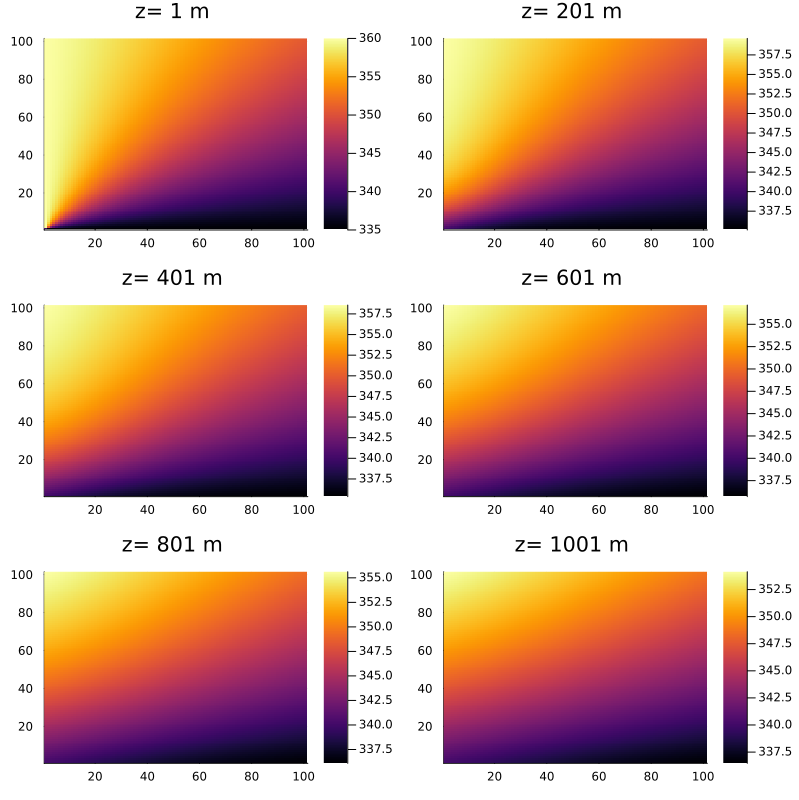

In [3]:
c_air=340.;
v_wind=[20.,-5.,0.];
#Even though the source corresponds to nodes, it is simpler to define it as a vector of floating point components.
SourcePoint=[1.,1.,1.];
c=map_speed(c_air,v_wind,SourcePoint,Nx,Ny,Nz);
#Plotting
######################
using Plots
x=1:1:Nx;
y=1:1:Ny;
 
p = plot(layout = (3, 2), size=(800,800))  # Create a layout for 6 plots arranged in 3 rows and 2 columns
for i in 1:6
    c_slice = c[:, :, 20*i-19]
    heatmap!(p[i], x, y, c_slice, title="z= "* string(200*i-199)  *" m ")
end
display(p)


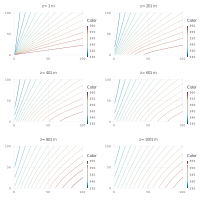

In [4]:
using Gadfly
Gadfly.set_default_plot_size(20cm, 20cm) ;
p = [];
for i in 1:6
    p2=Gadfly.plot(z=c[:,:,20*i-19], Geom.contour,Coord.Cartesian(xmin=0, xmax=101, ymin=0, ymax=101),
        Guide.title("z= "* string(200*i-199)  *" m "))
    push!(p, p2)
end
gridstack([p[1] p[2]; p[3] p[4];p[5] p[6]])


# Fast Sweeping method of Eikonal package

Ref: https://github.com/triscale-innov/Eikonal.jl/blob/main/docs/ripple-tank/ripple-tank.md

In [5]:
using Eikonal

# Define the slowness field sigma in the Eikonal context
sigma = 1.0 ./ c;

fs = FastSweeping(sigma);

# Source point. We must use integers here
source_point = (1, 1, 1);

# Initialize the wavefront arrival time at the source point
init!(fs, source_point);

@time sweep!(fs, verbose=true);

#The time matrix fs.t is initialized with an additional dimension in each direction to handle boundary conditions.
#This is done to avoid out-of-range index problems during the sweeping calculation. 
#The additional values in fs.t represent the travel times in the “ghost cells” outside the real calculation domain.
#Therefore, fs.t is a matrix of dimension (Nx+1) x (Ny+1) x (Nz+1).


iter 1, sweep 1: change = 0.0
iter 1, sweep 2: change = 0.0
iter 1, sweep 3: change = Inf
iter 1, sweep 4: change = Inf
iter 1, sweep 5: change = Inf
iter 1, sweep 6: change = 0.0
iter 1, sweep 7: change = Inf
iter 1, sweep 8: change = Inf
iter 2, sweep 1: change = Inf
iter 2, sweep 2: change = Inf
iter 2, sweep 3: change = 0.028571428571428466
iter 2, sweep 4: change = 0.1634808685027588
iter 2, sweep 5: change = 0.0
iter 2, sweep 6: change = 0.0
iter 2, sweep 7: change = 0.00029072876928101066
iter 2, sweep 8: change = 0.004371540579305227
iter 3, sweep 1: change = 0.06259898618717956
iter 3, sweep 2: change = 0.0003858396411675286
iter 3, sweep 3: change = 7.163627257419449e-5
iter 3, sweep 4: change = 1.1506290158835531e-5
iter 3, sweep 5: change = 0.0
iter 3, sweep 6: change = 0.0
iter 3, sweep 7: change = 1.2798338934742958e-5
iter 3, sweep 8: change = 3.963191687921736e-6
iter 4, sweep 1: change = 1.6083983358669665e-5
iter 4, sweep 2: change = 2.873766090884272e-5
iter 4, sweep

In [10]:
using Gadfly
using Cairo
using Fontconfig
travel_time_FSM=fs.t[1:Nx,1:Ny,1:Nz];
Gadfly.set_default_plot_size(20cm, 20cm) ;
p = [];
for i in 1:6
    p2=Gadfly.plot(z=travel_time_FSM[:,:,20*i-19], Geom.contour,Coord.Cartesian(xmin=0, xmax=101, ymin=0, ymax=101),Guide.xlabel("x (m)"),
    Guide.ylabel("y (m)"),Guide.title("z="* string(200*i-199)  *" m "),Guide.colorkey(title ="Traveltime (s)"))
    if i==1
        Gadfly.push!(p2, layer(x=[SourcePoint[1]], y=[SourcePoint[2]], Geom.point, Theme(default_color="red")))
    end
    push!(p, p2)
end
gridstack([p[1] p[2]; p[3] p[4];p[5] p[6]])
draw(PNG("gadflyFS3D_1.png", 8inch, 6inch), p[1])
draw(PNG("gadflyFS3D_201.png", 8inch, 6inch), p[2])
draw(PNG("gadflyFS3D_401.png", 8inch, 6inch), p[3])
draw(PNG("gadflyFS3D_601.png", 8inch, 6inch), p[4])
draw(PNG("gadflyFS3D_801.png", 8inch, 6inch), p[5])
draw(PNG("gadflyFS3D_1001.png", 8inch, 6inch), p[6])